# Installing and Importing Dependencies

| Requirement | Description |
| ----------- | ----------- |
| torch | The core PyTorch library for deep learning. |
| transformers | Hugging Face Transformers library, providing pre-trained models like BERT. |
| AdamW | An optimizer commonly used with Transformers models. |
| get_linear_schedule_with_warmup | Creates a learning rate scheduler for optimization. |
| sklearn.metrics | Metrics from scikit-learn to evaluate model performance. |
| warnings.filterwarnings('ignore') | Suppresses warnings; not ideal for production code, but might be done here for brevity in the example. |

In [ ]:
!pip install transformers

In [2]:

import torch
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Setting Variables

|Variable | Description |
|---      |---           |
| PRE_TRAINED_MODEL_NAME | Specifies the BERT model to use (cased version, sensitive to capitalization). |
| DEVICE | Check for CUDA (GPU) availability; otherwise defaults to CPU. |
| TOKENIZER | Loads the BERT tokenizer for text preprocessing. |
| EPOCHS | Number of training iterations. |
| MAX_LEN | Maximum sequence length for tokenization. |
| BATCH_SIZE | Batch size for training. |
| INITIAL_TEST_SIZE | Percentage of data to be held out for initial testing |
| RANDOM_SEED | For reproducibility |
| VALIDATION_SIZE | Percentage of the initial test set to use for validation |

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TOKENIZER = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
EPOCHS=10
MAX_LEN=512
BATCH_SIZE=16
INITIAL_TEST_SIZE = 0.2  
RANDOM_SEED = 42         
VALIDATION_SIZE = 0.5  

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Reading and Preprocessing Data

In [37]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split as tts

# df = pd.read_csv('https://raw.githubusercontent.com/animesharma3/SPAM-SMS-Detection/master/spam_sms_collection.csv')[['name_email', 'bot']]
df = pd.read_csv('https://raw.githubusercontent.com/lovestaco/bot-bot-signup-to-newsletter/main/spam_signup_collection.csv')[['name_email', 'bot']]

df.head(2)

,msg,spam
0,athreya athreyac4@gmail.com,0
1,Withdrawing 32 911 Dollars. G t withdrwl >>> ...,1
2,Carlos cgsaid@ucasal.edu.ar,0
3,Jack dalonng@gmail.com,0
4,You got 54 877 US dollars. Gt withdrwl >>> h...,1


In [39]:
class NewsletterCollectionDataset(Dataset):
    """
    Creates a PyTorch Dataset for bot sign up detection with a BERT tokenizer.

    Args:
        bot: Labels for each sample (0 or 1).
        name_emails:  List of email/name text samples.
        tokenizer: BERT tokenizer for preprocessing.
        max_len:  Maximum sequence length. 
    """    
    def __init__(self, bots, name_emails, tokenizer, max_len):
        self.name_emails = name_emails
        self.bots = bots
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.name_emails)

    def __getitem__(self, i):
        name_email = str(self.name_emails[i])
        bot = self.bots[i]

        encoding = self.tokenizer.encode_plus(
            name_email,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'name_email': name_email,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'bot': torch.tensor(bot, dtype=torch.long)
        }

In [41]:
# Split the data into training and testing sets

df_train, df_test = tts(df, 
                        test_size=INITIAL_TEST_SIZE, 
                        random_state=RANDOM_SEED
                        )

# Further split the testing set into a validation set and a final testing set

df_val, df_test = tts(df_test, 
                      test_size=VALIDATION_SIZE, 
                      random_state=RANDOM_SEED,
                      )

# Check the shapes of the resulting datasets
print("Training set shape:", df_train.shape)
print("Validation set shape:", df_val.shape)
print("Testing set shape:", df_test.shape)


((144, 2), (18, 2), (18, 2))

In [40]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    """
    Creates a PyTorch DataLoader for bot detection.

    Args:
        df (pandas.DataFrame): The DataFrame containing email/name data and 'bot' labels.
        tokenizer: The BERT tokenizer for text preprocessing.
        max_len (int): The maximum length for tokenized sequences.
        batch_size (int): Number of samples per batch.

    Returns:
        torch.utils.data.DataLoader: A DataLoader instance for iterating over the dataset.
    """
    
    ds = NewsletterCollectionDataset(
        bots=df['bot'].to_numpy(),
        name_emails=df['name_email'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [42]:
# Creating model data for training, validation, and testing. 
train_data_loader = create_data_loader(df_train, TOKENIZER, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, TOKENIZER, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, TOKENIZER, MAX_LEN, BATCH_SIZE)


d = next(iter(train_data_loader)) 

# Shapes of data in the batch
print("Input IDs shape:", d['input_ids'].shape)
print("Attention Mask shape:", d['attention_mask'].shape)
print("Labels (bot) shape:", d['bot'].shape)

# Example of a preprocessed text sample 
print("Example Text:", d['name_email'][0])  # Assuming the first item is the raw text
print("Example Input IDs:", d['input_ids'][0])


# Model Building

In [45]:
import torch.nn as nn

class BotClassifier(nn.Module):
    """
    A neural network model for spam classification using a pre-trained BERT model.

    Attributes:
        n_classes (int): The number of output classes (e.g., 2 for bot vs. human).

    """

    def __init__(self, n_classes):
        super(BotClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        """
        Defines the forward pass through the spam classification model.

        Args:
            input_ids (torch.Tensor): Tokenized input sequences.
            attention_mask (torch.Tensor): Attention mask indicating real vs. padded tokens.

        Returns:
            torch.Tensor: The model's output logits (un normalized class probabilities).
        """

        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        return self.out(output)


In [46]:
model = BotClassifier(n_classes=2)
model = model.to(DEVICE)

# Loss, Optimizer and Scheduler

In [47]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(DEVICE)

# Train Model Function

In [48]:
import numpy as np
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    device,
    data_loader,
    n_examples
):
    """
    Trains a model for a single epoch on a specified dataset.

    This function performs a single training loop over a provided PyTorch DataLoader. 
    For each batch, it calculates the loss, updates the model's weights (backpropagation), 
    and tracks training accuracy and loss.

    Args:
        model (nn.Module): The PyTorch model to train.
        loss_fn (nn.Module): The loss function for calculating error.
        optimizer (torch.optim.Optimizer): The optimizer used for updating model parameters.
        scheduler: A learning rate scheduler to adjust learning rate during training.
        device (torch.device): The device where the model and data should be loaded ('cpu' or 'cuda')
        data_loader (torch.utils.data.DataLoader): A DataLoader providing batches of training data.
        n_examples (int): The total number of training examples in the dataset. 

    Returns:
        tuple: A tuple containing:
            * train_acc (float): Training accuracy for the epoch.
            * train_loss (float): Average training loss for the epoch.
    """

    model = model.train()  # Sets the model to training mode 

    losses = []
    correct_predictions = 0

    for d in data_loader:
        # Data preparation
        input_ids = d['input_ids'].to(device) 
        attention_mask = d['attention_mask'].to(device) 
        targets = d['bot'].to(device) 

        # Forward pass 
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Loss calculation
        loss = loss_fn(outputs, targets)

        # Accuracy calculation
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Back propagation 
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        
        # Optimization
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad() 

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

# Validating Model Function

In [49]:
def evaluate_model(
    model,
    loss_fn,
    device,
    data_loader,
    n_examples
):
    """
    Evaluates the performance of a model on a given dataset.

    This function calculates the accuracy and loss of the provided model on a DataLoader, 
    without updating the model's weights (since this is for evaluation, not training).

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        loss_fn (nn.Module): The loss function to calculate error.
        device (torch.device): The device to use for computation ('cpu' or 'cuda').
        data_loader (torch.utils.data.DataLoader): A DataLoader providing batches of evaluation data.
        n_examples (int): The total number of evaluation examples.

    Returns:
        tuple: A tuple containing:
            * eval_acc (float): The evaluation accuracy for the dataset.
            * eval_loss (float): The average evaluation loss for the dataset.
    """

    model = model.eval()  # Sets the model to evaluation mode (disables dropout, etc.)

    losses = []
    correct_predictions = 0

    with torch.no_grad():  # Disables gradient calculations for efficiency
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['bot'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    eval_acc = correct_predictions.double() / n_examples
    eval_loss = np.mean(losses)

    return eval_acc, eval_loss 


# Training the Model

In [50]:
%%time
from collections import defaultdict 


def start_training():
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train(
        model,
        loss_fn,
        optimizer,
        scheduler,
        device,
        train_data_loader,
        len(df_train)
    )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = evaluate_model(
        model,
        loss_fn,
        device,
        val_data_loader,
        len(df_val)
    )

        print(f'Validation loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

start_training()

Epoch 1/10
----------
Train loss 0.4524265229701996 accuracy 0.8125
Validation loss 0.13861329853534698 accuracy 0.9444444444444444

Epoch 2/10
----------
Train loss 0.13377878804587656 accuracy 0.9722222222222222
Validation loss 0.01685995887964964 accuracy 1.0

Epoch 3/10
----------
Train loss 0.13878986306695473 accuracy 0.9583333333333333
Validation loss 0.6645699292421341 accuracy 0.7777777777777777

Epoch 4/10
----------
Train loss 0.1918790644267574 accuracy 0.9444444444444444
Validation loss 0.18694046174641699 accuracy 0.9444444444444444

Epoch 5/10
----------
Train loss 0.018076400777014594 accuracy 0.9930555555555555
Validation loss 0.11930578161263838 accuracy 0.9444444444444444

Epoch 6/10
----------
Train loss 0.0007173250616890275 accuracy 1.0
Validation loss 0.0005039466195739806 accuracy 1.0

Epoch 7/10
----------
Train loss 0.001489059077963854 accuracy 1.0
Validation loss 0.1403410683851689 accuracy 0.9444444444444444

Epoch 8/10
----------
Train loss 0.0003758141473

# Evaluating the Model Performance

In [51]:
test_acc, _ = evaluate_model(
    model,
    loss_fn,
    DEVICE,
    test_data_loader,
    len(df_test)
)
test_acc.item()

0.8333333333333333

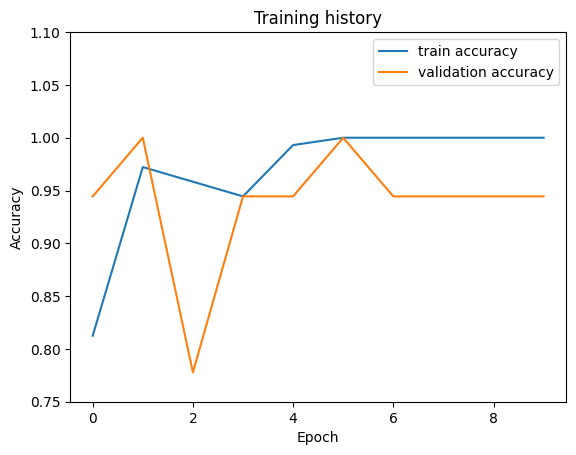

In [98]:
import matplotlib.pyplot as plt

# Assuming history['train_acc'] is a list of tensors
train_acc_tensors = history['train_acc']
val_acc_tensors = history['val_acc']

# Convert each tensor to CPU and then to NumPy array
train_acc_np = [tensor.cpu().numpy() for tensor in train_acc_tensors]
val_acc_np = [tensor.cpu().numpy() for tensor in val_acc_tensors]

def get_accuracy():
    # Plot using NumPy arrays
    plt.plot(train_acc_np, label='train accuracy')
    plt.plot(val_acc_np, label='validation accuracy') 

    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0.75, 1.1])
    plt.show()

In [55]:
def get_predictions(
    model, data_loader
):
    model = model.eval()

    msgs = []
    predictions = []
    predictions_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            name_email = d['name_email']
            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            bot = d['bot'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            probs = torch.nn.functional.softmax(outputs, dim=1)

            msgs.extend(name_email)
            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(bot)
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return msgs, predictions, predictions_probs, real_values

In [56]:
y_msgs, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# Creating Final Classification Report

In [57]:
import seaborn as sns

def create_classification_report(Y_test, Y_pred):
    print('--------Classification Report---------\n')
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred)
    metrices = [accuracy, f1, precision, recall, roc_auc]
    scores = pd.DataFrame(pd.Series(metrices).values, index=['accuracy', 'f1-score', 'precision', 'recall', 'roc auc score'], columns=['score'])
    print(scores)
    print('\n--------Plotting Confusion Matrix---------')
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, cmap='RdYlGn_r', annot_kws={'size': 16})
    return scores

In [93]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_model_info():

    model = BotClassifier(n_classes=2)
    model = model.to(DEVICE)
    num_parameters = count_parameters(model)

    if num_parameters >= 10**9:
        num_parameters_billions = num_parameters / 10**9
        print(f"The model has approximately {num_parameters_billions:.2f} billion trainable parameters")
    elif num_parameters >= 10**6:
        num_parameters_millions = num_parameters / 10**6
        print(f"The model has approximately {num_parameters_millions:.2f} million trainable parameters")
    else:
        print(f"The model has {num_parameters} trainable parameters")

    import os
    model_path = 'best_model_state.bin'
    file_size_bytes = os.path.getsize(model_path)
    file_size_mb = file_size_bytes / (1024 * 1024)
    print(f"The model file size is approximately {file_size_mb:.2f} MB")


--------Classification Report---------

                  score
accuracy       0.833333
f1-score       0.888889
precision      1.000000
recall         0.800000
roc auc score  0.900000

--------Plotting Confusion Matrix---------


,score
accuracy,0.833333
f1-score,0.888889
precision,1.000000
recall,0.800000
roc auc score,0.900000


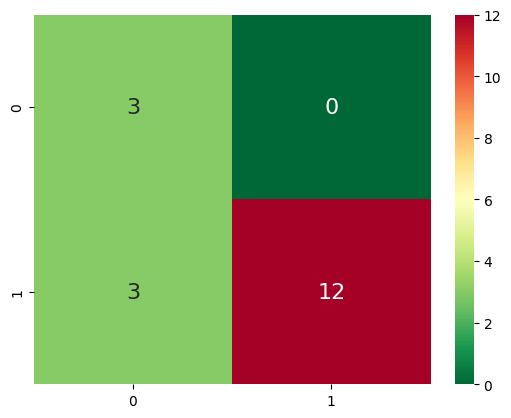

In [100]:
create_classification_report(y_test, y_pred)

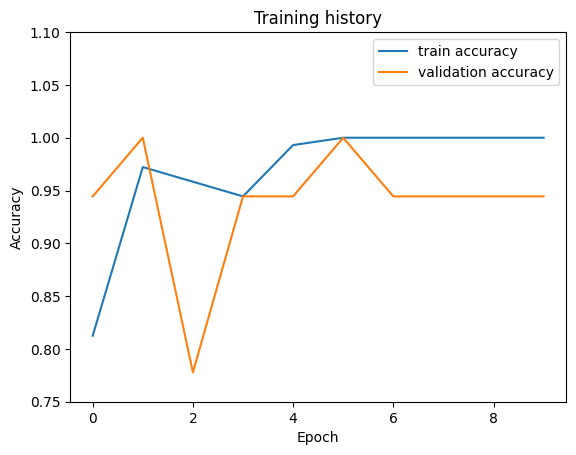

In [101]:
get_accuracy()

In [1]:
# Step 1: Prepare the data

email = "rishic2013@gmail.com"
name = "Rishi C"

# email = "lama2@hexmos.com"
# name = "Lama2.  G t 12 withdrwl >>> "

data_to_test = name + email
def test_with_single_data(data_to_test):
    encoding = TOKENIZER.encode_plus(
    data_to_test,
    add_special_tokens=True,
    max_length=MAX_LEN,
    truncation=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors="pt",
)

# Move the tensors to the device where the model is
    input_ids = encoding["input_ids"].to(DEVICE)
    attention_mask = encoding["attention_mask"].to(DEVICE)

# Step 2: Predict
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prob = torch.nn.functional.softmax(outputs, dim=1)

# Step 3: Interpret the prediction
    prediction = torch.argmax(prob, dim=1).item()
    if prediction == 1:
        print("The signup is likely from a bot. ")
    else:
        print("The signup is likely from a human.")

test_with_single_data(data_to_test)

get_model_info()


NameError: name 'tokenizer' is not defined